In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

# Analysis of Boston and Seattle Airbnb Open Data

## Questions answered by the Analysis:<br>
### 1. How much AirBNB homes are earning in certain areas? <br>
### 2. Is there anything about the properties that helps predict price? <br> 
### 3. Compare rates between Seattle and Boston. Are they different? <br>

## Future works:<br>
### Can you find negative and positive reviews based on text? <br>

## Collecting Data - Reading csv files

We will first load and analyse data from Boston collected in 2020-02-13 <br>
The dataset was downloaded from the link https://www.kaggle.com/airbnb/boston and https://www.kaggle.com/airbnb/seattle/data 


In [3]:
df_boston_listings = pd.read_csv('../data/boston/old/listings.csv')

### Getting 7 random samples using the method df.sample() <br>
It is usually better to get random samples than the first (head) or last (tail) rows because  we get more data variability

In [4]:
df_boston_listings.sample(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
894,7618925,https://www.airbnb.com/rooms/7618925,20160906204935,2016-09-07,4 Beds 2 Baths in Luxury Brownstone,Well-designed four bedrooms with two bathrooms...,A well-balanced blend of modern and historic. ...,Well-designed four bedrooms with two bathrooms...,none,"Located in historic Fort Hill (Highland Park),...",This is my personal home that I love to share ...,Logan Airport: Take an airport shuttle bus fro...,"Three dedicated pantries (with cups, mugs, bow...",I'm a social and hospitable host who loves to ...,Shoes off apartment (slippers available to gue...,https://a2.muscache.com/im/pictures/3695bdb3-0...,https://a2.muscache.com/im/pictures/3695bdb3-0...,https://a2.muscache.com/im/pictures/3695bdb3-0...,https://a2.muscache.com/im/pictures/3695bdb3-0...,11228809,https://www.airbnb.com/users/show/11228809,Jonathan,2014-01-12,"Boston, Massachusetts, United States","Born and raised in Boston, to parents from for...",within a few hours,100%,100%,t,https://a2.muscache.com/im/pictures/94d51baa-6...,https://a2.muscache.com/im/pictures/94d51baa-6...,Roxbury,6,6,"['email', 'phone', 'facebook', 'amex', 'review...",t,t,"Alvah Kittredge Park, Boston, MA 02119, United...",Roxbury,Roxbury,NaN,Boston,MA,02119,Boston,"Boston, MA",US,United States,42.329640,-71.092741,t,Apartment,Entire home/apt,8,2.0,4.0,5.0,Real Bed,"{""Cable TV"",""Wireless Internet"",""Air Condition...",NaN,$625.00,NaN,NaN,"$1,200.00",$150.00,0,$0.00,2,1125,today,NaN,0,0,21,111,2016-09-06,1,2016-08-07,2016-08-07,100.0,10.0,10.0,10.0,10.0,4.0,8.0,f,NaN,NaN,f,moderate,f,f,6,0.94
3558,14592644,https://www.airbnb.com/rooms/14592644,20160906204935,2016-09-07,New flat with a terrace in the heart of Cambridge,"Located in very center, between Harvard and MI...",NaN,"Located in very center, between Harvard and MI...",none,NaN,NaN,NaN,NaN,Call me if have any questions.,This is a non smoking apartment. No l,https://a2.muscache.com/im/pictures/2c6af5f0-0...,https://a2.muscache.com/im/pictures/2c6af5f0-0...,https://a2.muscache.com/im/pictures/2c6af5f0-0...,https://a2.muscache.com/im/pictures/2c6af5f0-0...,13993089,https://www.airbnb.com/users/show/13993089,Nonna,2014-04-07,"Newport Beach, California, United States",We live in Newport beach.\r\nWe are couple wit...,within a few hours,100%,100%,f,https://a2.muscache.com/im/pictures/8d788688-2...,https://a2.muscache.com/im/pictures/8d788688-2...,NaN,2,2,"['email', 'phone', 'reviews', 'kba']",t,t,"Western Ave, Cambridge, MA 02139, United States",NaN,Allston,NaN,Cambridge,MA,02139,Boston,"Cambridge, MA",US,United States,42.363472,-71.115701,f,

In [5]:
df_boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

## Data cleaning
<li> Transform monetary columns to float
<li> Clean % symbol from percentage columns 
<li> drop columns with less than 25% of the rows filled in 
<li> Drop columns that are redundant or highly correlated with other columns

### Transform monetary columns that is originaly a string to float. <br>
Eg. '$ 1,023.43' will be converted to 1023.43



In [6]:
monetary_cols = ['price','security_deposit','cleaning_fee','extra_people','weekly_price', 'monthly_price']
df_boston_listings[monetary_cols] = df_boston_listings[monetary_cols].astype(str).applymap(lambda x: re.sub('[$,]', '', x) if x is not None else x).astype(float)


String columns with the % symbol are transformed to float removing the % from the string

In [7]:
rate_cols = ['host_response_rate','host_acceptance_rate']
df_boston_listings[rate_cols] = df_boston_listings[rate_cols].astype(str).applymap(lambda x: re.sub('[%]', '', x) if x is not None else x).astype(float)

### drop weekly_price and monthly_price 
Those columns are dropped as they are high correlated with price.

In [8]:
df_boston_listings = df_boston_listings.drop(columns=['weekly_price','monthly_price'])

### drop neighbourhood, zipcode as they are correlated with neighbourhood_cleansed

In [9]:
df_boston_listings = df_boston_listings.drop(columns=['neighbourhood','zipcode'])

### drop columns with less than 25% of the data filled

In [10]:
df_boston_listings = df_boston_listings.dropna(thresh=df_boston_listings.shape[0]*.25, axis=1)

## 1. How much AirBNB homes are earning in certain areas?
To answer this question, we will analyse price by neighbourhood

### Plotting price distribution by neighbourhood

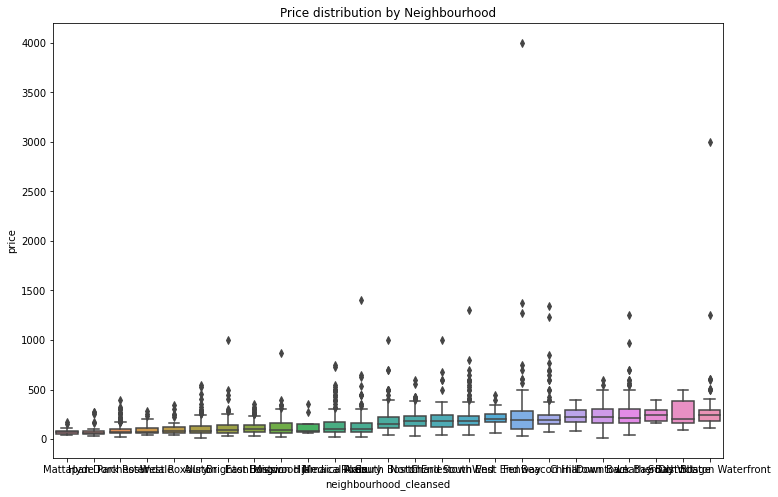

In [11]:
mean_order = list(df_boston_listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values().index)
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='neighbourhood_cleansed', y='price', data=df_boston_listings, order=mean_order);
ax.set_title('Price distribution by Neighbourhood');

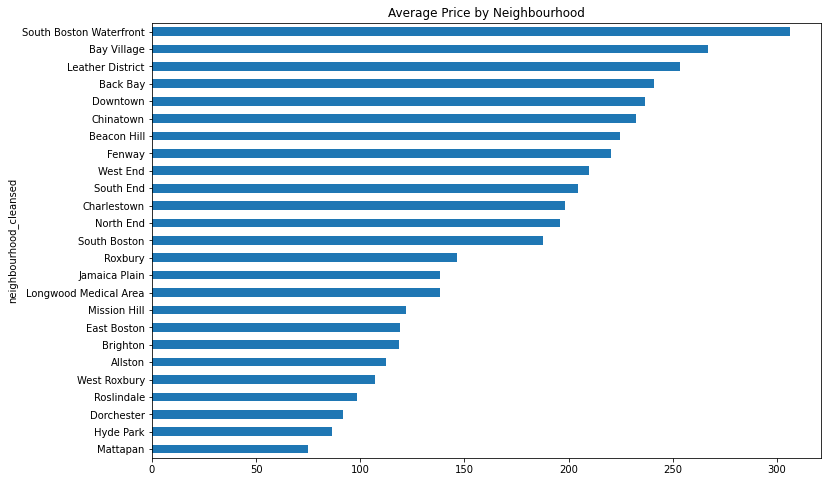

In [12]:
plt.figure(figsize=(12,8))
ax = df_boston_listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values().plot(kind='barh');
ax.set_title('Average Price by Neighbourhood');

In [13]:
df_boston_listings['price'].describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

### Initial results - There are a lot of outliers
Checking the box plot above we can see that there are some data points over the upper limit. Those outliers are probably influencing and shifting the price average. <br>

Let us make a deep analysis and remove those outliers. 


For each neighbourhood, we will remove data point that have price value above the Box Plot 'upper limit quantile'. <br>
The formula is: Q3 + 1.5*(Q3-Q1). 

<p> More information about Box plot 'upper limit quantile' and how to calculate it, check the following links: <br>

<a href="https://www.six-sigma-material.com/Box-Plot.html#:~:text=The%20highest%20point%20of%20the,interquartile%20distance%20from%20each%20quartile."> Box Plot </a> <br>
<a href="https://numpy.org/doc/stable/reference/generated/numpy.quantile.html"> numpy quantile </a> 

In [14]:
upper_1_5_IQR = df_boston_listings.groupby('neighbourhood_cleansed')['price'].agg(
        lambda x: np.quantile(x, 0.75) + (np.quantile(x, 0.75) - np.quantile(x, 0.25))*1.5
        )
upper_1_5_IQR = upper_1_5_IQR.to_dict()

df_boston_listings['upper_1_5_IQR'] = df_boston_listings['neighbourhood_cleansed'].map(upper_1_5_IQR)

df_boston_listings_wo_upper = df_boston_listings[df_boston_listings['price']<=df_boston_listings['upper_1_5_IQR']]



Now that we have a dataset without the upper limit outliers, let us plot the price average by neighbourhood again

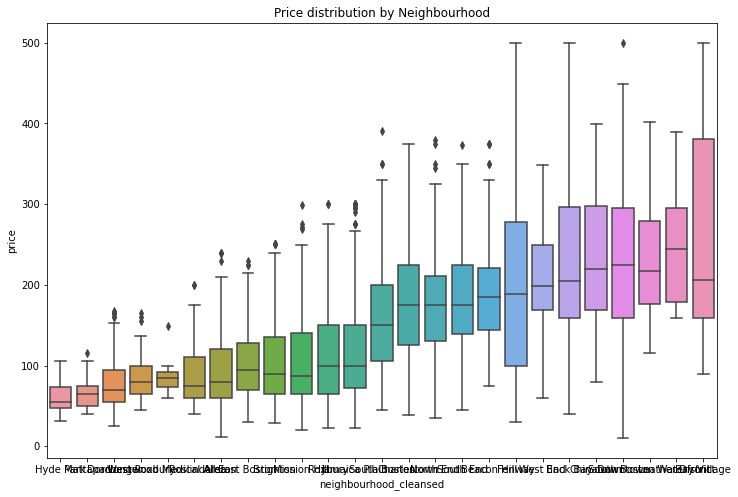

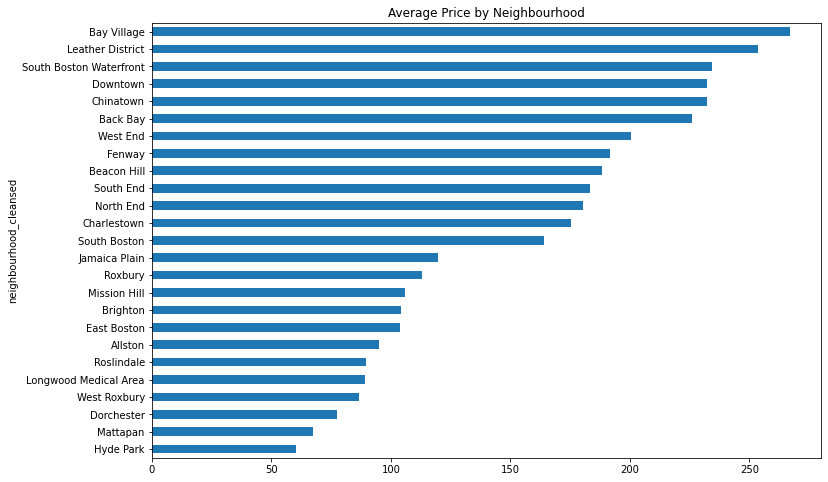

In [15]:
mean_order = list(df_boston_listings_wo_upper.groupby('neighbourhood_cleansed')['price'].mean().sort_values().index)
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='neighbourhood_cleansed', y='price', data=df_boston_listings_wo_upper, order=mean_order);
ax.set_title('Price distribution by Neighbourhood');

plt.figure(figsize=(12,8))
ax = df_boston_listings_wo_upper.groupby('neighbourhood_cleansed')['price'].mean().sort_values().plot(kind='barh');
ax.set_title('Average Price by Neighbourhood');

In [16]:
print('Total rows on the Original dataset = ', df_boston_listings.shape[0])
print('Total rows after removing wrong input and upper limit quantile = ', df_boston_listings_wo_upper.shape[0])
print(f'Total rows rate after data cleaning {np.round(df_boston_listings_wo_upper.shape[0]/df_boston_listings.shape[0]*100,2)}%')

Total rows on the Original dataset =  3585
Total rows after removing wrong input and upper limit quantile =  3383
Total rows rate after data cleaning 94.37%


In [17]:
df_boston_listings_wo_upper['price'].describe()

count    3383.000000
mean      154.883831
std        87.771330
min        10.000000
25%        80.000000
50%       140.000000
75%       200.000000
max       500.000000
Name: price, dtype: float64

In [18]:
df_boston_listings = df_boston_listings_wo_upper
df_boston_listings = df_boston_listings.drop(columns='upper_1_5_IQR')

## 1. Results after removing outliers

After removing the upper limit quantile outliers, we have still keept 94% of the original data, the overall average price has dropped from \$173 to \$154. 

<p>The bar plot above is now a more realistic view of the average price by neighbourhood. <br>

### How much AirBNB homes are earning in certain areas? </b> <br>
There is clearly difference on price rates depending on the neighbourhood. <br>
We could classify the neighbourhoods in 3 price ranges:
<li>up to $100
<li>from $100 to $170
<li>above $170







## 2. Is there anything about the properties that helps predict price?

To answer this question, we wil do some steps:
<li> First plot the correlation matrix for the numerical columns vs price, 
<li> Apply ANOVA Test for categorical features
<li> Model a linear regression and analyse the coeficients



### plot the correlation matrix for numerical columns

<AxesSubplot:>

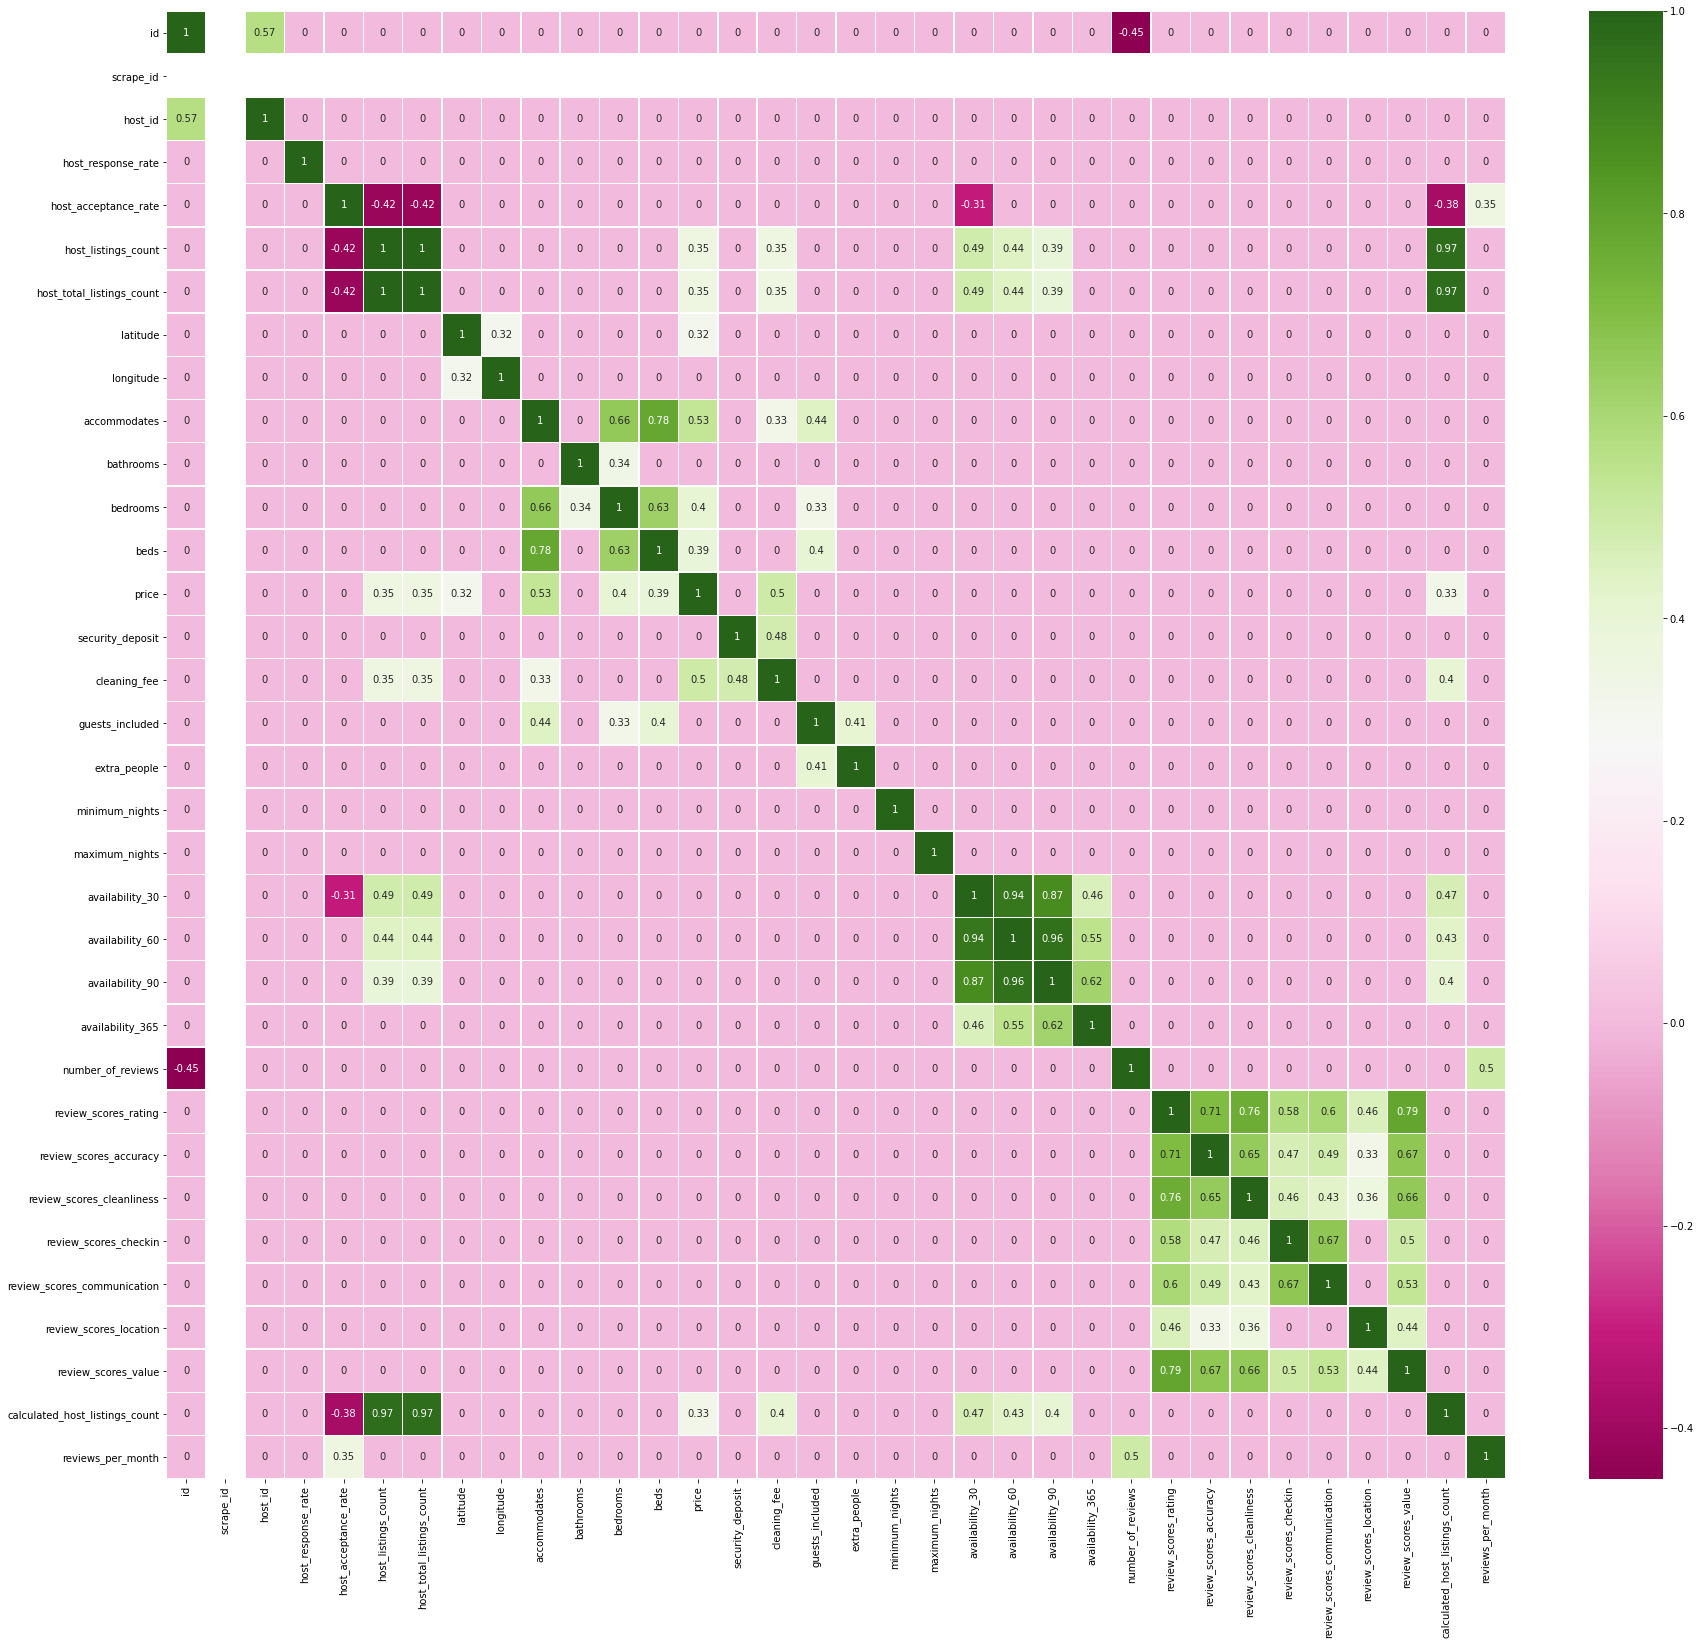

In [45]:
#sns.heatmap(df_boston_listings.corr())

correlation_matrix = df_boston_listings.corr().round(2)
correlation_matrix = correlation_matrix.applymap(lambda x:  0 if x<0.3 and x>-0.3 else x)

plt.figure(figsize=(30,27))
sns.heatmap(corr.round(2), annot=True,linewidths=.5, cmap="PiYG")

We will only keep the columns that have a corelation with 'price' greater than 0.3, which is considered low-medium strength.<br>

In [46]:
correlation_matrix['price'].loc[correlation_matrix.price>0].sort_values(ascending=False)

price                             1.00
accommodates                      0.53
cleaning_fee                      0.50
bedrooms                          0.40
beds                              0.39
host_listings_count               0.35
host_total_listings_count         0.35
calculated_host_listings_count    0.33
latitude                          0.32
Name: price, dtype: float64

In [48]:
correlated_columns = df_boston_listings.select_dtypes(np.number).columns[correlation_matrix.price>0]
continuous = correlated_columns 


### categorical independent variables
There are 52 categorical columns on the original dataset. <br>
First we will eliminame categoricals features that are not significant based on ANOVA test

In [49]:
categoricals = df_boston_listings.select_dtypes(exclude=np.number).columns

print('Total categorical columns = ', len(categoricals))

Total categorical columns =  53


In [50]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OrdinalEncoder

X = df_boston_listings[categoricals].astype(str).fillna('unknow')
y = df_boston_listings['price']

enc = OrdinalEncoder()
X_enc = enc.fit_transform(X)

F, pval = f_classif(X_enc, y)

result_anova = pd.DataFrame({'categoricals':categoricals, 'p_values':pval})

categoricals = result_anova[(~result_anova['p_values'].isnull()) & (result_anova['p_values'] < 0.05)].categoricals

print ('Total categoricals after applying ANOVA Test = ', len(categoricals))

Total categoricals after applying ANOVA Test =  40


Good! Using the ANOVA test, we have removed columns that are not statistical significant. This reduced from 52 categorical columns to 40.

Now, we will work only with the categorical columns with low cardinality (few levels). Categorical columns with high cardinality (many levels) is a problem because when we use one-hot-enconding, each level becames a columns and most of the machine learning algorithms perform bad when the number of columns is too high. <br><br>

Let us have a look at the unique values on each category:


In [51]:
df_boston_listings[categoricals].nunique().sort_values()

require_guest_phone_verification       2
instant_bookable                       2
is_location_exact                      2
host_identity_verified                 2
host_is_superhost                      2
require_guest_profile_picture          2
room_type                              3
cancellation_policy                    4
market                                 4
host_response_time                     4
bed_type                               5
property_type                         13
neighbourhood_cleansed                25
calendar_updated                      37
host_neighbourhood                    52
host_verifications                    81
host_location                        169
first_review                         946
street                              1184
host_about                          1189
notes                               1198
host_since                          1249
host_name                           1275
interaction                         1524
neighborhood_ove

If we include the high cardinality column in the model using the one-hot-enconding, we would have more columns than rows. <br> 
So, for this project we will pick only the categoricals columns with less than m/10 unique values. m is this case is the total number of rows on the dataset. 

In [52]:
low_card_cols = df_boston_listings[categoricals].columns[df_boston_listings[categoricals].nunique() < df_boston_listings.shape[0]/10]

#df_boston_listings[low_card_cols].sample(7)

In [53]:
print('Categorical columns picking only the low cardinality categories = ',df_boston_listings[low_card_cols].shape[1])

df_boston_listings[low_card_cols].nunique().sort_values()

Categorical columns picking only the low cardinality categories =  17


is_location_exact                     2
instant_bookable                      2
require_guest_profile_picture         2
host_identity_verified                2
require_guest_phone_verification      2
host_is_superhost                     2
room_type                             3
market                                4
host_response_time                    4
cancellation_policy                   4
bed_type                              5
property_type                        13
neighbourhood_cleansed               25
calendar_updated                     37
host_neighbourhood                   52
host_verifications                   81
host_location                       169
dtype: int64

Great. Total categoricals columns have been reduced from 52 to 40 using ANOVA Test, and then reduced from 40 to 17 picking only columns with low cardinality (few levels).

<p> Let us check the columns and their p_values

In [54]:
result_anova[result_anova.categoricals.isin(list(low_card_cols))].sort_values(by='p_values')

,categoricals,p_values
40,room_type,0.000000e+00
51,require_guest_phone_verification,7.045021e-145
20,host_location,1.350145e-77
49,cancellation_policy,6.381708e-57
41,bed_type,2.071946e-50
39,property_type,3.613216e-18
48,instant_bookable,7.593562e-14
34,market,2.190130e-13
26,host_neighbourhood,2.675387e-11
31,neighbourhood_cleansed,2.157674e-07


### We are now almost ready to build our first model.
<p>Until this point, we have used a generic approach that could have been applied to any dataset:
<li> Check correlation matrix for continuous features, 
<li> Clean upper limit quantile (outliers), 
<li> ANOVA Test for categoricals features
<li> Drop categoricals with high cardinality.

<p> We could go further and include some more steps like:
<li> analyse each categorical column on the dataset and work on data cleaning, 
<li> use domain knowledge
<li> apply NLP to long text columns. 
<li> transform datetime columns to integer number of days or months

<br>But we will stop at this point to keep the process simple. 

### Model a Linear Regression with the selected features

Setting features to fit the linear regression

In [55]:
numeric_features = list(continuous)
numeric_features.remove('price')

categorical_features = list(low_card_cols)

X = df_boston_listings[numeric_features+categorical_features]
y = df_boston_listings['price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=311)



###  Building the model structure with scikit-learn Pipeline. <br>
More info about scikit-learn pipeline can be found <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html"> here </a>
<p> Those are the steps to build our model: 
<li>For numeric features we will apply a SimpleImputer to fill Nan values with the median <br>
<li>For categorical features we will apply a SimpleImputer to fill NaN values with constant 'missing' and then transform the columns to <li>OneHotEncoding (dummy variables) <br>
<li>Fit a LinearRegression model using scikit-learn library

In [56]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), #strategy='mean'
#    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    ,('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())
                      ]
               ,verbose=True)

pipe.fit(X_train,y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.2s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['host_listings_count',
                                                   'host_total_listings_count',
                                                   'latitude', 'accommodates',
                                                   'bedrooms', 'beds',
                                                   'cleaning_fee',
                                                   'calculated_host_listings_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                

Evaluating model performance

In [57]:
yhat_train = pipe.predict(X_train)
yhat_valid = pipe.predict(X_valid)

print('R2 Score on train set = ', r2_score(y_train, yhat_train))
print('R2 Score on validation set = ', r2_score(y_valid, yhat_valid), '\n')

print('RMSE on train set = ', mean_squared_error(y_train, yhat_train, squared=False))
print('RMSE on train set = ', mean_squared_error(y_valid, yhat_valid, squared=False))



R2 Score on train set =  0.7462011942167949
R2 Score on validation set =  0.6345762312247946 

RMSE on train set =  44.05063260393185
RMSE on train set =  53.8138608896065


Calculate feature importance

In [58]:
ohe_feature_names = pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical_features)
feature_names =numeric_features+list(ohe_feature_names)#+categorical_avg_freq

classifier = pipe.named_steps['regressor']
print('\nmodel: ', type(classifier).__name__)

importances_ = np.transpose(classifier.coef_) if 'coef_' in classifier.__dict__.keys() else classifier.feature_importances_
df_importances = pd.DataFrame(data=importances_, index= feature_names, columns=['importance'])

df_importances['abs_importance'] = np.abs(df_importances.importance)

df_importances.sort_values(by='importance',ascending=False)


model:  LinearRegression


,importance,abs_importance
latitude,307.747935,307.747935
"host_location_Fort Lauderdale, Florida, United States",197.301996,197.301996
"host_location_Norwich, Vermont, United States",173.110106,173.110106
"host_location_Quito, Pichincha, Ecuador",167.646474,167.646474
host_neighbourhood_Bernal Heights,141.980606,141.980606
property_type_Villa,141.648923,141.648923
calendar_updated_23 months ago,118.698895,118.698895
"host_location_Buenos Aires, Argentina",114.688355,114.688355
"host_location_Ashland, Massachusetts, United States",112.076023,112.076023
"host_verifications_['email', 'phone', 'amex', 'kba']",106.243013,106.243013


In [59]:
df_importances.abs_importance.describe()

count    387.000000
mean      29.573761
std       35.606528
min        0.052911
25%        8.131628
50%       19.100028
75%       35.763267
max      307.747935
Name: abs_importance, dtype: float64

In [60]:
print('Overall price average = ', '$154')
print('Baseline standard error = ', '$87.7')


print('Average error using the Linear Model = ','$53.8')
print('Improvement over the baseline = ', '$33.9')

Overall price average =  $154
Baseline standard error =  $87.7
Average error using the Linear Model =  $53.8
Improvement over the baseline =  $33.9


## 2. Results after feature analysis and modelling 

### Is there anything about the properties that helps predict price?

The following continuous columns are potential good predictors of price, according to the correlation with Price:

| Feature | correlation |
| --- | --- |
| accommodates |                    | 0.53 |
| cleaning_fee |                    | 0.50 |
| bedrooms |                        | 0.40 |
| square_feet |                     | 0.40 |
| beds |                            | 0.39 |
| host_listings_count |             | 0.35 |
| host_total_listings_count |       | 0.35 |
| calculated_host_listings_count |  | 0.33 |
| latitude |                        | 0.32 |

The following categorical columns are potential good predictors os price, according to ANOVA Test and low_cardinality analysis:
 
| categoricals | ANOVA p_values |
| --- | --- | 
| room_type	| 0.000000e+00 |
| require_guest_phone_verification	| 7.045021e-145 |
| host_location	| 1.350145e-77 |
| cancellation_policy |	6.381708e-57 |
| bed_type	| 2.071946e-50 |
| property_type	| 3.613216e-18 |
| instant_bookable	| 7.593562e-14 |
| market	| 2.190130e-13 |
| host_neighbourhood	| 2.675387e-11 |
| neighbourhood_cleansed	| 2.157674e-07 |
| host_identity_verified	| 6.211245e-07 |
| calendar_updated	| 9.434674e-07 |
| is_location_exact	| 9.098670e-05 |
| require_guest_profile_picture	| 6.685695e-04 |
| host_verifications	| 3.178332e-03 |
| host_response_time	| 3.363136e-03 |
| host_is_superhost	| 1.658695e-02 |

#### Model performance:

R2 Score on validation set =  0.63,  which means that 63% of the price variance can be explained by the model.

The overall average price is \$154 and the Baseline standard error is \$87.7.
The Linear Regression model build on this project has a RMSE on test-set = \$53.8. <br>
Using the model we were able to reduce the standard error from \$87.7 to \$53.8, which is a 38% improvement over the baseline.



#### Model coeficients:

The model has been fit with a lot of dummy categoricals features (one-hot-encoding), that turns the coeficient analysis hard because each level is transformed into one column. However, the coeficient analysis is still usefull to see if any variable is affecting the price with positive or negative weight. 

<p>Examples:

<p> host_location_Fort Lauderdale, Florida, United States has a positive coeficient 196.87 <br>
host_location_Chatham, Massachusetts, United States	has a negative coeficient -222.85


## 3. Compare rates between Seattle and Boston. Are they different? <br>

To answer this question, we will:
<li> load the Seattle dataset
<li> apply some data cleaning 
<li> Compare the average price in each City with basic stats
<li> Compare average price with some graphics.

### Loading Seattle dataset

In [61]:
# https://www.kaggle.com/airbnb/seattle/data

df_seattle_listings = pd.read_csv('../data/seattle/old/listings.csv')



### Apply data cleaning

In [62]:
# tranform price to float
df_seattle_listings['price'] = df_seattle_listings['price'].astype(str).apply(lambda x: re.sub('[$,]', '', x) if x is not None else x).astype(float)


# remove the upper limit as we have done with Boston dataset
upper_1_5_IQR = df_seattle_listings.groupby('neighbourhood_cleansed')['price'].agg(
        lambda x: np.quantile(x, 0.75) + (np.quantile(x, 0.75) - np.quantile(x, 0.25))*1.5
        )
upper_1_5_IQR = upper_1_5_IQR.to_dict()

df_seattle_listings['upper_1_5_IQR'] = df_seattle_listings['neighbourhood_cleansed'].map(upper_1_5_IQR)

df_seattle_listings_wo_upper = df_seattle_listings[df_seattle_listings['price']<=df_seattle_listings['upper_1_5_IQR']]

df_seattle_listings = df_seattle_listings_wo_upper

### Compare the overall average price between Boston and Seattle

In [63]:
print('Average price in Boston = ', np.round(df_boston_listings['price'].mean(),2))
print('Average price in Seattle = ', np.round(df_seattle_listings['price'].mean(),2))

Average price in Boston =  154.88
Average price in Seattle =  112.08


Apply the ztest to check if the difference of mean price between Boston and Seattle is statistically significant. <br>
For more info about the hypothesis test, check the url. https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html <br>



In [64]:
sm.stats.ztest(df_boston_listings["price"].dropna(), df_seattle_listings["price"].dropna())

(24.303959725824853, 1.780183448065634e-130)

A p_value lower than 0.05 means that the difference is signifcant. <br>
As expected, the mean diference is significant. The p_value is nearly 0 (1.780183448065634e-130), which is lower than 0.05. 

### Plot comparative graphics

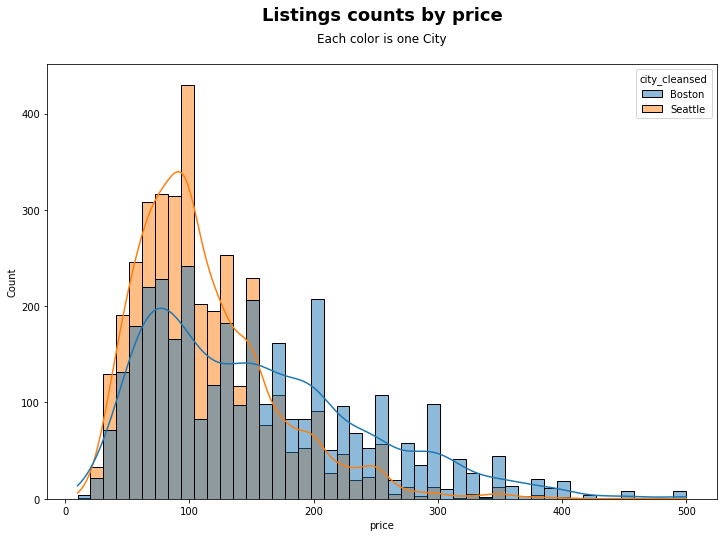

In [65]:
df_boston_listings['city_cleansed'] = 'Boston'
df_seattle_listings['city_cleansed'] = 'Seattle'

seattle_boston = df_boston_listings[['price', 'city_cleansed']].append(df_seattle_listings[['price', 'city_cleansed']])
ax = sns.histplot(data=seattle_boston, x='price', hue='city_cleansed',kde=True);
plt.text(x=0.5, y=1.1, s="Listings counts by price", fontsize=18, weight='bold', ha="center", transform=ax.transAxes);
plt.text(x=0.5, y=1.05, s= "Each color is one City", fontsize=12, ha="center", transform=ax.transAxes);

## Results - average price are different

### 3. Compare rates between Seattle and Boston. Are they different?
### Yes, they are different. 
The average price in Seattle is lower than in Boston. The difference is clear when we have calculate the average price for Boston, \$154 vs \$108 for Seattle. The difference has also been confirmed with the ztest above.

Finally, the last histogram presents the price distribution on both cities. <br>
Checking the histogram, the Counts of prices up to \$160 is higher in Seattle. The Counts of prices above \$160 is higher in Boston. 

